In [1]:
import torch
import sys, os
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
from datetime import datetime
from ema_pytorch import EMA
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Normal
from utils.sim_utils import *
from utils.vec_sim_utils import *
from utils.couzin_utils import *
from utils.encoder_utils import *
from tqdm.auto import tqdm
from multiprocessing import Pool, set_start_method
from models.ModularNetworks import PairwiseInteraction, Attention
from torch.utils.data import TensorDataset, DataLoader
from utils.train_utils import compute_wasserstein_loss, gradient_penalty
from geomloss import SamplesLoss

sys.path.insert(0, os.path.abspath('..'))

[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Discriminator(nn.Module):
    def __init__(self, encoder, role, z_dim=32):
        super(Discriminator, self).__init__()
        self.encoder = encoder
        self.role = role
        self.z_dim = z_dim
        self.input_dim = 2 * z_dim

        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def encoder_forward(self, tensor):
        states = tensor[..., :5] if self.role == "prey" else tensor[..., :4]
        _, trans = self.encoder(states)
        batch, frames_minus_one, agent, neigh_rep = trans.shape
        feats = trans.reshape(batch * frames_minus_one * agent, neigh_rep)
        return feats, (batch, frames_minus_one, agent)

    def forward(self, tensor):
        features, shape = self.encoder_forward(tensor)
        batch, frames_minus_one, agent = shape

        params = torch.relu(self.fc1(features))
        params = torch.relu(self.fc2(params))
        params = torch.relu(self.fc3(params))
        params = self.fc4(params).squeeze(-1)

        matrix = params.view(batch, frames_minus_one, agent)
        return matrix

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp,
               noise=0, generation=None, num_generations=None):

        if noise > 0.0:
            noise_until = 0.5 * num_generations
            decay = 1.0 - (generation / noise_until)
            decay = max(0.0, decay)
            noise_term = noise * decay

            expert_batch = expert_batch.clone()
            policy_batch = policy_batch.clone()

            expert_batch = expert_batch + torch.randn_like(expert_batch) * noise_term 
            policy_batch = policy_batch + torch.randn_like(policy_batch) * noise_term

        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)

        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)

        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)

        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }

    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()


In [3]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [4]:
#https://github.com/yiftachbeer/mmd_loss_pytorch/blob/master/mmd_loss.py

class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.register_buffer(
            "bandwidth_multipliers",
            mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        )
        self.bandwidth = bandwidth
        
    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)
        return torch.as_tensor(self.bandwidth, device=L2_distances.device, dtype=L2_distances.dtype)

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, encoder, role, kernel=RBF()):
        super().__init__()
        self.encoder = encoder
        self.role = role
        self.kernel = kernel

    def encode_transitions(self, tensor):
        states = tensor[..., :5] if self.role == "prey" else tensor[..., :4]
        _, transitions = self.encoder(states)
        features = transitions.reshape(-1, transitions.size(-1))
        return features

    def forward(self, expert_batch, generative_batch):
        X = self.encode_transitions(expert_batch)
        Y = self.encode_transitions(generative_batch)

        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        mmd_loss = XX - 2 * XY + YY
        return mmd_loss

In [5]:
def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations,
                      rel_clip=0.01, abs_clip=None, min_clip=1e-12, return_metrics=True):

    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward

    delta_raw = (lr / (2 * sigma**2 * num_perturbations)) * grad  
    delta_raw_norm = delta_raw.norm().clamp_min(1e-12)        

    theta_norm = theta.norm().clamp_min(1e-12)
    max_delta_norm = rel_clip * theta_norm

    if abs_clip is not None:
        max_delta_norm = torch.minimum(max_delta_norm, theta.new_tensor(abs_clip))
    max_delta_norm = torch.maximum(max_delta_norm, theta.new_tensor(min_clip))

    clip_ratio = (max_delta_norm / delta_raw_norm).clamp(max=1.0)
    delta = delta_raw * clip_ratio 

    theta_new = theta + delta

    if return_metrics:
        return theta_new, {
            "theta_norm": float(theta_norm.item()),
            "delta_raw_norm": float(delta_raw_norm.item()),
            "delta_norm": float(delta.norm().item()),
            "max_delta_norm": float(max_delta_norm.item()),
            "clip_ratio": float(clip_ratio.item()),
        }

    return theta_new



def discriminator_reward(discriminator, gen_tensor, mode="mean"):
    matrix = discriminator(gen_tensor) # (batch, frames_minus_one, agent)

    if mode == "mean":
        scores = matrix.mean(dim=(1, 2))
        return scores.mean()
    
    if mode == "top":
        k = 0.2
        flat = matrix.flatten(1)  # (B, (F-1)*A)
        K = max(1, int(flat.size(1) * k))
        return flat.topk(K, dim=1).values.mean()
    
    if mode == "avoid":
        d0 = 0.08
        temp = 0.02
        dx = gen_tensor[:, :-1, :, :, 0]
        dy = gen_tensor[:, :-1, :, :, 1]
        dist = torch.sqrt(dx * dx + dy * dy + 1e-8)  # (B, F-1, A, N)

        if discriminator.role == "prey":
            pred_dist = dist[:, :, :, 0]
        else:
            pred_dist = dist[:, :, :, 1:].amin(-1)

        weight = torch.sigmoid((d0 - pred_dist) / temp) + 0.05

        weighted_score = (matrix * weight).sum() / weight.sum()

        return weighted_score


def optimize_es(pred_policy, prey_policy, role, module, discriminator, lr, sigma, num_perturbations, device="cuda", init_pool=None, mode="mean"):

    if role == "prey":
        network = prey_policy.pairwise if module == 'pairwise' else prey_policy.attention
    else:
        network = pred_policy.pairwise if module == 'pairwise' else pred_policy.attention
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach()
    dim = theta.numel()

    eps = torch.randn(num_perturbations, dim, device=theta.device, dtype=theta.dtype) * sigma

    theta_pos = theta.unsqueeze(0) + eps
    theta_neg = theta.unsqueeze(0) - eps
    pert_theta = torch.cat([theta_pos, theta_neg], dim=0)

    pert_pred_tensor, pert_prey_tensor = run_env_vectorized(init_pool=init_pool, 
                                                            batch=2*num_perturbations,
                                                            prey_policy=prey_policy, 
                                                            pred_policy=pred_policy, 
                                                            n_prey=32, n_pred=1, es=True,
                                                            pred_speed=5, prey_speed=5,
                                                            max_steps=100, step_size=3,
                                                            area_width=2160, area_height=2160,
                                                            thetas=pert_theta, role=role, module=module)
    
    rewards = discriminator_reward(discriminator, pert_prey_tensor, mode=mode) if role == "prey" else discriminator_reward(discriminator, pert_pred_tensor, mode=mode)
    r_pos, r_neg = rewards[:num_perturbations], rewards[num_perturbations:]
    diffs = (r_pos - r_neg).detach()

    ranks = torch.argsort(torch.argsort(diffs)).float()
    ranks_norm = (ranks - ranks.mean()) / (ranks.std() + 1e-8)

    theta_est, grad_metrics = gradient_estimate(theta, ranks_norm, eps, sigma, lr, num_perturbations)

    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {"diff_min": round(diffs.min().item(), 6),
            "diff_max": round(diffs.max().item(), 6),
            "diff_mean": round(diffs.mean().item(), 6),
            "diff_std": round(diffs.std(unbiased=False).item(), 6),
            "delta_norm": round((theta_est - theta).norm().item(), 6),
            "clip_ratio": round(grad_metrics["clip_ratio"], 6),
            "delta_raw_norm": round(grad_metrics["delta_raw_norm"], 6),
            "max_delta_norm": round(grad_metrics["max_delta_norm"], 6)
        }


def pretrain_policy(policy, role, expert_data, batch_size=256, epochs=250, lr=1e-3, deterministic=True, device='cuda'):
    policy.train()

    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    n, frames, agents, neigh, features = expert_data.shape
    expert_data = expert_data.reshape(n * frames * agents, neigh, features)
    
    if role == "prey":
        states = expert_data[..., :5]
        actions = expert_data[:, 0, 5]
    else:
        states = expert_data[..., :4]
        actions = expert_data[:, 0, 4]

    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for states, actions in loader:
            states = states.to(device=device)
            actions = actions.to(device=device)
            
            action = policy.forward(states, deterministic=deterministic)

            if action.dim() == 2 and action.size(-1) == 1:
                action = action.squeeze(-1) 

            loss = F.mse_loss(action, actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * actions.size(0)

        if epoch % 25 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / (frames * agents):.6f}")

    return policy


def calculate_metrics(pred_policy=None, prey_policy=None, init_pool=None, 
                      pred_encoder=None, prey_encoder=None,
                      exp_pred_tensor=None, exp_prey_tensor=None,
                      pred_mmd_loss=None, prey_mmd_loss=None,
                      sinkhorn_loss=None, device=None):

    gen_pred_tensor, gen_prey_tensor = run_env_simulation(visualization='off', prey_policy=prey_policy, pred_policy=pred_policy,
                                                        n_prey=32, n_pred=1, max_steps=200, pred_speed=5, prey_speed=5, area_width=50, area_height=50, init_pool=init_pool)

    mmd_list = []
    sinkhorn_list = []
    for i in range(100):
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        expert_pred_batch = sample_data(exp_pred_tensor, batch_size=20, window_len=10).to(device)
        generative_pred_batch = sample_data(gen_pred_tensor, batch_size=20, window_len=10).to(device)


        # MMD Calculation
        with torch.no_grad():
            mmd_prey_metric = prey_mmd_loss.forward(expert_prey_batch, generative_prey_batch)
            mmd_pred_metric = pred_mmd_loss.forward(expert_pred_batch, generative_pred_batch)
        mmd_list.append((mmd_prey_metric.item(), mmd_pred_metric.item()))


        # Sinkhorn Calculation
        _, trans_exp_pred = pred_encoder(expert_pred_batch[...,:4])
        _, trans_gen_pred = pred_encoder(generative_pred_batch[...,:4])
        batch, frames, agents, dim = trans_exp_pred.shape
        pred_x = trans_exp_pred.reshape(batch * frames, agents, dim)
        pred_y = trans_gen_pred.reshape(batch * frames, agents, dim)

        _, trans_exp_prey = prey_encoder(expert_prey_batch[...,:5])
        _, trans_gen_prey = prey_encoder(generative_prey_batch[...,:5])
        batch, frames, agents, dim = trans_exp_prey.shape
        prey_x = trans_exp_prey.reshape(batch * frames, agents, dim)
        prey_y = trans_gen_prey.reshape(batch * frames, agents, dim)

        sinkhorn_pred = sinkhorn_loss(pred_x, pred_y)
        sinkhorn_prey = sinkhorn_loss(prey_x, prey_y)
        sinkhorn_list.append((sinkhorn_prey.mean().item(), sinkhorn_pred.mean().item()))


    mmd_pred_mean = np.mean([mmd[1] for mmd in mmd_list])
    mmd_pred_std = np.std([mmd[1] for mmd in mmd_list], ddof=1)

    mmd_prey_mean = np.mean([mmd[0] for mmd in mmd_list])
    mmd_prey_std = np.std([mmd[0] for mmd in mmd_list], ddof=1)

    sinkhorn_pred_mean = np.mean([sinkhorn[1] for sinkhorn in sinkhorn_list])
    sinkhorn_pred_std = np.std([sinkhorn[1] for sinkhorn in sinkhorn_list], ddof=1)

    sinkhorn_prey_mean = np.mean([sinkhorn[0] for sinkhorn in sinkhorn_list])
    sinkhorn_prey_std = np.std([sinkhorn[0] for sinkhorn in sinkhorn_list], ddof=1)

    return {
        "mmd_prey_mean": mmd_prey_mean,
        "mmd_prey_std": mmd_prey_std,
        "mmd_pred_mean": mmd_pred_mean,
        "mmd_pred_std": mmd_pred_std,
        "sinkhorn_prey_mean": sinkhorn_prey_mean,
        "sinkhorn_prey_std": sinkhorn_prey_std,
        "sinkhorn_pred_mean": sinkhorn_pred_mean,
        "sinkhorn_pred_std": sinkhorn_pred_std
    }

In [6]:
# Training
num_generations = 1500
gamma = 0.999

# Policy
lr_policy = 1e-3
num_perturbations = 32
sigma = 0.1
deterministic=True
reward_mode = "mean"

# Discriminator
dis_balance_factor = 2
noise = 0.005
lr_disc = 5e-5
lambda_gp = 5

performance_eval = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'

pred_files = []
prey_files = []

for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)


init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


In [8]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=5, optimizer=prey_optimizer, role="prey")#1000

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=5, optimizer=pred_optimizer, role="predator") #500

for p in pred_encoder.parameters():
    p.requires_grad = False

print("Predator Encoder trained & frozen.")

Prey Encoder trained & frozen.

Predator Encoder trained & frozen.


In [9]:
prey_policy = ModularPolicy(features=5).to(device)
pretrain_policy(prey_policy, "prey", expert_data=exp_prey_tensor, batch_size=4048, epochs=3, lr=1e-3, deterministic=deterministic, device=device)
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Prey Policy pretrained.\n")

pred_policy = ModularPolicy(features=4).to(device)
pretrain_policy(pred_policy, "predator", expert_data=exp_pred_tensor, batch_size=4048, epochs=3, lr=1e-3, deterministic=deterministic, device=device)
ema_pred = EMA(pred_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Predator Policy pretrained.\n")

Prey Policy pretrained.

Predator Policy pretrained.



In [10]:
# Prey Expert MMD: 0.057 ± 0.066
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

# Pred Expert MMD: 0.059 ± 0.049
pred_mmd_loss = MMDLoss(encoder=pred_encoder, role="predator").to(device)
pred_discriminator = Discriminator(encoder=pred_encoder, role="predator", z_dim=32).to(device)
pred_discriminator.set_parameters(init=True)
optim_disc_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

sinkhorn_loss = SamplesLoss(loss="sinkhorn", backend="tensorized")

In [11]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model.to("cpu")
    rollout_pred_policy = ema_pred.ema_model.to("cpu")
    
    gen_pred_tensor, gen_prey_tensor = run_env_simulation(visualization='off', prey_policy=rollout_prey_policy, pred_policy=rollout_pred_policy,
                                                           n_prey=32, n_pred=1, max_steps=100, pred_speed=5, prey_speed=5, area_width=50, area_height=50, init_pool=init_pool)

    for i in range(dis_balance_factor):
        # Prey Discriminator Update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        # Predator Discriminator Update (larger batch size for imbalance)
        expert_pred_batch = sample_data(exp_pred_tensor, batch_size=20, window_len=10).to(device)
        generative_pred_batch = sample_data(gen_pred_tensor, batch_size=20, window_len=10).to(device)

        dis_metric_pred = pred_discriminator.update(expert_pred_batch, generative_pred_batch, optim_disc_pred, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        disc_metrics_list.append((dis_metric_prey, dis_metric_pred))
        
    # Predator Policy Update
    pin_pred_metrics = optimize_es(pred_policy, prey_policy, "pred", "pairwise", pred_discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations, mode=reward_mode, init_pool=init_pool)
    an_pred_metrics  = optimize_es(pred_policy, prey_policy, "pred", "attention", pred_discriminator, lr=lr_policy, sigma=sigma,num_perturbations=num_perturbations, mode=reward_mode, init_pool=init_pool)
    ema_pred.update()

    # Prey Policy Update
    pin_prey_metrics = optimize_es(pred_policy, prey_policy, "prey", "pairwise", prey_discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations, mode=reward_mode, init_pool=init_pool  )
    an_prey_metrics  = optimize_es(pred_policy, prey_policy, "prey", "attention", prey_discriminator, lr=lr_policy, sigma=sigma,num_perturbations=num_perturbations, mode=reward_mode, init_pool=init_pool)
    ema_prey.update()

    policy_metrics_list.append({"predator": (pin_pred_metrics, an_pred_metrics), "prey": (pin_prey_metrics, an_prey_metrics)})
    
    lr_policy *= gamma
    sigma *= gamma

    current_prey_state = ema_prey.ema_model.state_dict()
    current_pred_state = ema_pred.ema_model.state_dict()

    if gen % performance_eval == 0:
        metrics = calculate_metrics(pred_policy, prey_policy, init_pool, 
                      pred_encoder, prey_encoder, exp_pred_tensor, exp_prey_tensor,
                      pred_mmd_loss, prey_mmd_loss, sinkhorn_loss, device="cuda")
        metrics_list.append(metrics)

        best_prey = metrics["mmd_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

        best_pred = metrics["mmd_pred_mean"]
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}
        
    if metrics["mmd_prey_mean"] < best_prey:
        best_prey = metrics["mmd_prey_mean"]
        print(f"New best Prey MMD: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

    if metrics["mmd_pred_mean"] < best_pred:
        best_pred = metrics["mmd_pred_mean"]
        print(f"New best Predator MMD: {best_pred.item()}\n")
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}

    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.4f} ± {metrics['sinkhorn_prey_std']:.4f}\n")
    print("--------------------------------")
    print(f"[PRED] PIN Network:   {pin_pred_metrics}")
    print(f"[PRED] AN Network:    {an_pred_metrics}")
    print(f"[PRED] Discriminator: {dis_metric_pred}")
    print(f"[PRED] Score Diff: {abs(dis_metric_pred['expert_score_mean'] - dis_metric_pred['policy_score_mean'])}")
    print(f"[PRED] MMD: {metrics['mmd_pred_mean']:.4f} ± {metrics['mmd_pred_std']:.4f} | Sinkhorn: {metrics['sinkhorn_pred_mean']:.4f} ± {metrics['sinkhorn_pred_std']:.4f}\n")


prey_policy.load_state_dict(best_prey_policy_state, strict=True)
pred_policy.load_state_dict(best_pred_policy_state, strict=True)

TypeError: run_env_vectorized() got an unexpected keyword argument 'thetas'

In [ ]:
base_dir = Path(r"..\data\2. Training\training\VideoPredPrey - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

prey_path = run_dir / "prey_policy.pth"
torch.save(prey_policy.state_dict(), prey_path)

pred_path = run_dir / "pred_policy.pth"
torch.save(pred_policy.state_dict(), pred_path)

In [ ]:
def get_expert_values(exp_pred_tensor, exp_prey_tensor, 
                      prey_mmd_loss, pred_mmd_loss, 
                      prey_encoder, pred_encoder, 
                      sinkhorn_loss, device):
    
    prey_mmd_list = []
    pred_mmd_list = []

    prey_sinkhorn_list = []
    pred_sinkhorn_list = []

    exp_pred_tensor = exp_pred_tensor.to(device)
    exp_prey_tensor = exp_prey_tensor.to(device)

    for i in tqdm(range(1000)):
        # MMD
        expert_pred_batch1 = sample_data(exp_pred_tensor, batch_size=10, window_len=10)
        expert_pred_batch2 = sample_data(exp_pred_tensor, batch_size=10, window_len=10)

        expert_prey_batch1 = sample_data(exp_prey_tensor, batch_size=10, window_len=10)
        expert_prey_batch2 = sample_data(exp_prey_tensor, batch_size=10, window_len=10)

        prey_mmd = prey_mmd_loss(expert_prey_batch1, expert_prey_batch2).item()
        pred_mmd = pred_mmd_loss(expert_pred_batch1, expert_pred_batch2).item()

        prey_mmd_list.append(prey_mmd)
        pred_mmd_list.append(pred_mmd)

        # Sinkhorn
        _, trans_exp_pred = pred_encoder(expert_pred_batch1[...,:4])
        _, trans_gen_pred = pred_encoder(expert_pred_batch2[...,:4])
        batch, frames, agents, dim = trans_exp_pred.shape
        pred_x = trans_exp_pred.reshape(batch * frames, agents, dim)
        pred_y = trans_gen_pred.reshape(batch * frames, agents, dim)

        _, trans_exp_prey = prey_encoder(expert_prey_batch1[...,:5])
        _, trans_gen_prey = prey_encoder(expert_prey_batch2[...,:5])
        batch, frames, agents, dim = trans_exp_prey.shape
        prey_x = trans_exp_prey.reshape(batch * frames, agents, dim)
        prey_y = trans_gen_prey.reshape(batch * frames, agents, dim)

        sinkhorn_pred = sinkhorn_loss(pred_x, pred_y)
        sinkhorn_prey = sinkhorn_loss(prey_x, prey_y)

        prey_sinkhorn_list.append(sinkhorn_prey.mean().item())
        pred_sinkhorn_list.append(sinkhorn_pred.mean().item())


    print(f"\nExpert Prey MMD: {np.mean(prey_mmd_list)} ± {np.std(prey_mmd_list)}")
    print(f"Expert Pred MMD: {np.mean(pred_mmd_list)} ± {np.std(pred_mmd_list)}\n")

    print(f"Expert Prey Sinkhorn: {np.mean(prey_sinkhorn_list)} ± {np.std(prey_sinkhorn_list)}")
    print(f"Expert Pred Sinkhorn: {np.mean(pred_sinkhorn_list)} ± {np.std(pred_sinkhorn_list)}\n")

    mmd_means = (np.mean(prey_mmd_list), np.mean(pred_mmd_list))
    mmd_stds = (np.std(prey_mmd_list), np.std(pred_mmd_list))

    sinkhorn_means = (np.mean(prey_sinkhorn_list), np.mean(pred_sinkhorn_list))
    sinkhorn_stds = (np.std(prey_sinkhorn_list), np.std(pred_sinkhorn_list))

    return mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds

mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(exp_pred_tensor, exp_prey_tensor, 
                      prey_mmd_loss, pred_mmd_loss, 
                      prey_encoder, pred_encoder, 
                      sinkhorn_loss, device)

100%|██████████| 1000/1000 [01:04<00:00, 15.53it/s]


Expert Prey MMD: 0.041121254205703735 ± 0.03288686633291369
Expert Pred MMD: 0.2371663933992386 ± 0.10871220548230932

Expert Prey Sinkhorn: 0.00023239985574036837 ± 4.1004607112792516e-05
Expert Pred Sinkhorn: 0.0008489577872678638 ± 0.00016477687658751167



In [ ]:
def plot_train_metrics(disc_metrics, role="prey", save_dir=None):
    disc_dicts = [x[0] if role == "prey" else x[1] for x in disc_metrics]
    disc_df = pd.DataFrame(disc_dicts)
    disc_df["gen"] = (disc_df.index // dis_balance_factor) + 1
    disc_mean = disc_df.groupby("gen").mean(numeric_only=True).sort_index()

    gens = np.arange(len(disc_mean))

    score_diffs = (disc_mean["expert_score_mean"] - disc_mean["policy_score_mean"]).abs().to_numpy()
    abs_scores = disc_mean[["expert_score_mean", "policy_score_mean"]].to_numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # Left: Absolute scores
    axes[0].plot(gens, abs_scores[:, 0], label="Expert Score")
    axes[0].plot(gens, abs_scores[:, 1], label="Policy Score")
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("Score")
    axes[0].set_title(f"{role.upper()} Absolute Scores over Generations")
    axes[0].legend()
    axes[0].grid(True)

    # Right: Score diffs
    axes[1].plot(gens, score_diffs, color="orange")
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Score Difference")
    axes[1].set_title(f"{role.upper()} Score Difference over Generations")
    axes[1].grid(True)

    plt.tight_layout()

    plot_path = save_dir / f"disc_{role}_metrics.png"
    fig.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()


def plot_eval_metrics(metrics_list, 
                      mmd_means=None, sinkhorn_means=None, 
                      mmd_stds=None, sinkhorn_stds=None,
                      role="prey", save_dir=None,
                      eval_steps=5, max_steps=1500):
    
    xs = np.arange(len(metrics_list)) * eval_steps

    if role == "prey":
        mmd_mean = np.array([m["mmd_prey_mean"] for m in metrics_list], dtype=float)
        mmd_std  = np.array([m["mmd_prey_std"]  for m in metrics_list], dtype=float)
        sk_mean  = np.array([m["sinkhorn_prey_mean"] for m in metrics_list], dtype=float)
        sk_std   = np.array([m["sinkhorn_prey_std"]  for m in metrics_list], dtype=float)
        exp_mmd_mean = mmd_means[0]
        exp_mmd_std = mmd_stds[0]
        exp_sinkhorn_mean = sinkhorn_means[0]
        exp_sinkhorn_std = sinkhorn_stds[0]
    else:
        mmd_mean = np.array([m["mmd_pred_mean"] for m in metrics_list], dtype=float)
        mmd_std  = np.array([m["mmd_pred_std"]  for m in metrics_list], dtype=float)
        sk_mean  = np.array([m["sinkhorn_pred_mean"] for m in metrics_list], dtype=float)
        sk_std   = np.array([m["sinkhorn_pred_std"]  for m in metrics_list], dtype=float)
        exp_mmd_mean = mmd_means[1]
        exp_mmd_std = mmd_stds[1]
        exp_sinkhorn_mean = sinkhorn_means[1]
        exp_sinkhorn_std = sinkhorn_stds[1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    axes[0].plot(xs, mmd_mean, label=f"{role.upper()} MMD")
    axes[0].fill_between(xs, mmd_mean - mmd_std, mmd_mean + mmd_std, alpha=0.2)
    axes[0].axhline(exp_mmd_mean, color="red", linewidth=2, label="Expert MMD Mean ± Std")
    axes[0].fill_between(xs, exp_mmd_mean - exp_mmd_std, exp_mmd_mean + exp_mmd_std, alpha=0.2)
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("MMD")
    axes[0].set_title(f"{role.upper()} MMD (Mean ± Std)")
    axes[0].set_xlim(0, max_steps)
    axes[0].grid(True)

    axes[1].plot(xs, sk_mean, label=f"{role.upper()} Sinkhorn")
    axes[1].fill_between(xs, sk_mean - sk_std, sk_mean + sk_std, alpha=0.2)
    axes[1].axhline(exp_sinkhorn_mean, color="red", linewidth=2, label="Expert Sinkhorn Mean ± Std")
    axes[1].fill_between(xs, exp_sinkhorn_mean - exp_sinkhorn_std, exp_sinkhorn_mean + exp_sinkhorn_std, alpha=0.2)
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Sinkhorn")
    axes[1].set_title(f"{role.upper()} Sinkhorn (Mean ± Std)")
    axes[1].set_xlim(0, max_steps)
    axes[1].grid(True)

    plt.tight_layout()

    filename = f"eval_{role}_metrics.png"
    plot_path = save_dir / filename
    fig.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()



def plot_es_metrics(policy_metrics, role="prey", save_dir=None):
    gens = np.arange(len(policy_metrics))
    pms = [pm[role] for pm in policy_metrics]

    pin_delta_norm = np.array([pm[0].get("delta_norm", np.nan) for pm in pms], dtype=float)
    an_delta_norm  = np.array([pm[1].get("delta_norm", np.nan) for pm in pms], dtype=float)

    pin_diff_std = np.array([pm[0].get("diff_std", np.nan) for pm in pms], dtype=float)
    an_diff_std  = np.array([pm[1].get("diff_std", np.nan) for pm in pms], dtype=float)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    axes[0].plot(gens, pin_delta_norm, label="PIN delta_norm")
    axes[0].plot(gens, an_delta_norm, label="AN delta_norm")
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("delta_norm")
    axes[0].set_title(f"{role.upper()} ES step size per generation")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(gens, pin_diff_std, label="PIN diff_std")
    axes[1].plot(gens, an_diff_std, label="AN diff_std")
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("diff_std")
    axes[1].set_title(f"{role.upper()} Reward-diff std per generation")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()

    plot_path = save_dir / f"es_{role}_policy_metrics.png"
    fig.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()

plot_train_metrics(disc_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", mmd_means=mmd_means, mmd_stds=mmd_stds, sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)

NameError: name 'run_dir' is not defined

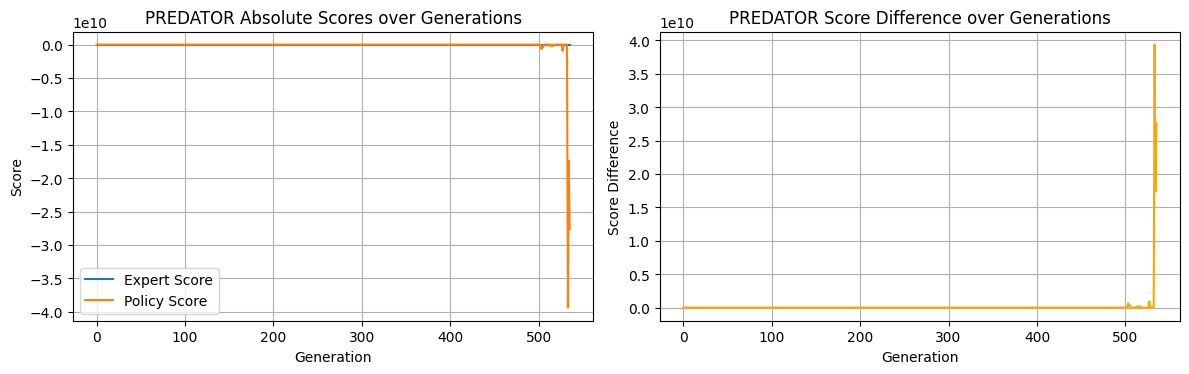

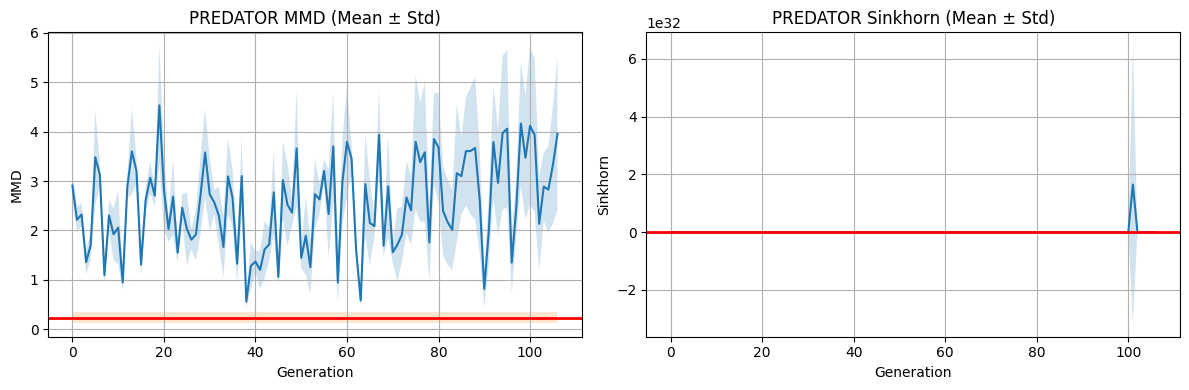

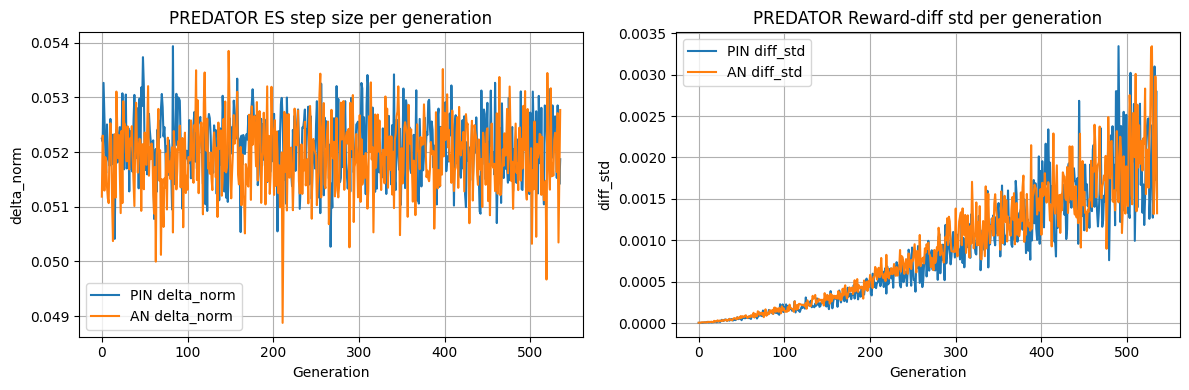

In [ ]:
plot_train_metrics(disc_metrics_list, role="predator", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="predator", mmd_means=mmd_means, mmd_stds=mmd_stds, sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="predator", save_dir=run_dir)

In [ ]:
%matplotlib tk
_, gen_prey_tensor = run_env_simulation(visualization='on', 
                                        prey_policy=prey_policy, pred_policy=pred_policy,
                                        n_prey=32, n_pred=1, max_steps=80,
                                        pred_speed=5, prey_speed=5,
                                        area_width=50, area_height=50, init_pool=init_pool)